# Install & Import Packages 

In [1]:
%pip install torch
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, f1_score

# Task 1

In [3]:
iris = load_iris()
x, y = iris.data, iris.target
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=43)
print(f'numero de caracteristicas: {len(x[0])}')
print(f'total de numero de entrenamiento: {len(x_train)}')
print(f'total de numero de testeo: {len(x_val)}')
print(f'conjunto total: {len(x)}')

numero de caracteristicas: 4
total de numero de entrenamiento: 105
total de numero de testeo: 45
conjunto total: 150


# Task 2

In [4]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self):
        super(SimpleFeedForwardNN, self).__init__()
        
        # Capa de entrada
        self.input_layer = nn.Linear(4, 10)  # 4 características de entrada y 10 neuronas en la capa oculta
        
        # Capa oculta
        self.hidden_layer = nn.Linear(10, 10)  # 10 neuronas en la capa oculta y 10 en la siguiente
        
        # Capa de salida
        self.output_layer = nn.Linear(10, 3)  # 10 neuronas en la capa oculta y 3 neuronas de salida
        
    def forward(self, x):
        # Pasar la entrada a través de la capa de entrada y luego aplicar ReLU
        x = nn.ReLU()(self.input_layer(x))
        
        # Pasar la salida anterior a través de la capa oculta y luego aplicar ReLU
        x = nn.ReLU()(self.hidden_layer(x))
        
        # Pasar la salida anterior a través de la capa de salida
        # Nota: No aplicamos Softmax aquí porque durante el entrenamiento utilizaremos
        # CrossEntropyLoss que ya aplica Softmax.
        return self.output_layer(x)
        


# Task 3

In [5]:
scaler = StandardScaler()

X = torch.tensor(scaler.fit_transform(x), dtype=torch.float32)
Y = torch.tensor(y, dtype=torch.int64)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model = SimpleFeedForwardNN()
print(model.parameters())

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_functions = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "MSELoss": nn.MSELoss(),
    "SmoothL1Loss": nn.SmoothL1Loss()
}

def evaluate_model(model, criterion, test_loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            
            if name in ["MSELoss", "SmoothL1Loss"]:
                targets = torch.nn.functional.one_hot(targets, 3).float()

            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)


for name, criterion in loss_functions.items():
    model.apply(lambda m: m.reset_parameters() if type(m) == nn.Linear else None)
    
    for epoch in range(50):
        model.train()
        total_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            if name in ["MSELoss", "SmoothL1Loss"]:
                targets = torch.nn.functional.one_hot(targets, 3).float()
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        test_loss = evaluate_model(model, criterion, test_loader)
        print(f"Epoch {epoch+1} [{name}] - Training Loss: {total_loss / len(train_loader):.4f}, Test Loss: {test_loss:.4f}")


<generator object Module.parameters at 0x7f305faafca0>
Epoch 1 [CrossEntropy] - Training Loss: 1.1426, Test Loss: 1.1583
Epoch 2 [CrossEntropy] - Training Loss: 1.1304, Test Loss: 1.1433
Epoch 3 [CrossEntropy] - Training Loss: 1.1179, Test Loss: 1.1287
Epoch 4 [CrossEntropy] - Training Loss: 1.1048, Test Loss: 1.1143
Epoch 5 [CrossEntropy] - Training Loss: 1.0920, Test Loss: 1.1006
Epoch 6 [CrossEntropy] - Training Loss: 1.0800, Test Loss: 1.0866
Epoch 7 [CrossEntropy] - Training Loss: 1.0655, Test Loss: 1.0728
Epoch 8 [CrossEntropy] - Training Loss: 1.0512, Test Loss: 1.0589
Epoch 9 [CrossEntropy] - Training Loss: 1.0386, Test Loss: 1.0453
Epoch 10 [CrossEntropy] - Training Loss: 1.0284, Test Loss: 1.0315
Epoch 11 [CrossEntropy] - Training Loss: 1.0145, Test Loss: 1.0179
Epoch 12 [CrossEntropy] - Training Loss: 1.0017, Test Loss: 1.0037
Epoch 13 [CrossEntropy] - Training Loss: 0.9921, Test Loss: 0.9893
Epoch 14 [CrossEntropy] - Training Loss: 0.9762, Test Loss: 0.9749
Epoch 15 [CrossE

# Task 4

In [6]:
# Redefinimos la red neuronal con Dropout
class RegularizedFeedForwardNN(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(RegularizedFeedForwardNN, self).__init__()
        
        self.input_layer = nn.Linear(4, 10)
        self.hidden_layer = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 3)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = nn.ReLU()(self.input_layer(x))
        x = self.dropout(x)  # Aplicar dropout
        x = nn.ReLU()(self.hidden_layer(x))
        x = self.dropout(x)  # Aplicar dropout
        x = self.output_layer(x)
        return x

# L1 Regularización
def l1_penalty(model):
    return sum(torch.sum(torch.abs(p)) for p in model.parameters())

# Función de entrenamiento con regularización L1
def train_with_l1(model, criterion, optimizer, train_loader, l1_lambda):
    model.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets) + l1_lambda * l1_penalty(model)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Hyperparámetros
EPOCHS = 50
L1_LAMBDA = 0.001
DROPOUT_RATE = 0.5

# Modelos con y sin regularización
models = {
    "Base Model": RegularizedFeedForwardNN(dropout_rate=0.0),
    "Dropout": RegularizedFeedForwardNN(dropout_rate=DROPOUT_RATE),
    "L1": RegularizedFeedForwardNN(dropout_rate=0.0),
    "L2": RegularizedFeedForwardNN(dropout_rate=0.0)
}

optimizers = {
    name: optim.Adam(model.parameters(), lr=0.001, weight_decay=(0.01 if name == "L2" else 0))
    for name, model in models.items()
}

for name, model in models.items():
    optimizer = optimizers[name]
    for epoch in range(EPOCHS):
        if name == "L1":
            train_loss = train_with_l1(model, nn.CrossEntropyLoss(), optimizer, train_loader, L1_LAMBDA)
        else:
            train_loss = evaluate_model(model, nn.CrossEntropyLoss(), train_loader)
        
        test_loss = evaluate_model(model, nn.CrossEntropyLoss(), test_loader)
        print(f"Epoch {epoch+1} [{name}] - Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1 [Base Model] - Training Loss: 1.1033, Test Loss: 1.1045
Epoch 2 [Base Model] - Training Loss: 1.1032, Test Loss: 1.1045
Epoch 3 [Base Model] - Training Loss: 1.1037, Test Loss: 1.1045
Epoch 4 [Base Model] - Training Loss: 1.1034, Test Loss: 1.1045
Epoch 5 [Base Model] - Training Loss: 1.1042, Test Loss: 1.1045
Epoch 6 [Base Model] - Training Loss: 1.1024, Test Loss: 1.1045
Epoch 7 [Base Model] - Training Loss: 1.1045, Test Loss: 1.1045
Epoch 8 [Base Model] - Training Loss: 1.1032, Test Loss: 1.1045
Epoch 9 [Base Model] - Training Loss: 1.1038, Test Loss: 1.1045
Epoch 10 [Base Model] - Training Loss: 1.1039, Test Loss: 1.1045
Epoch 11 [Base Model] - Training Loss: 1.1036, Test Loss: 1.1045
Epoch 12 [Base Model] - Training Loss: 1.1039, Test Loss: 1.1045
Epoch 13 [Base Model] - Training Loss: 1.1043, Test Loss: 1.1045
Epoch 14 [Base Model] - Training Loss: 1.1034, Test Loss: 1.1045
Epoch 15 [Base Model] - Training Loss: 1.1035, Test Loss: 1.1045
Epoch 16 [Base Model] - Training L

# Task 5

In [7]:
batch_sizes = {
    "SGD": 1,
    "Batch GD": len(train_data),
    "Mini-Batch GD": 32 
}

models = {name: SimpleFeedForwardNN() for name in batch_sizes.keys()}
optimizers = {name: optim.SGD(model.parameters(), lr=0.01) for name, model in models.items()}

for name, batch_size in batch_sizes.items():
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    model = models[name]
    optimizer = optimizers[name]
    
    print(f"Training with {name}")
    
    for epoch in range(50):
        model.train()
        start_time = time.time()
        total_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        test_loss = evaluate_model(model, nn.CrossEntropyLoss(), test_loader)
        
        print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}, Test Loss: {test_loss:.4f}, Time: {elapsed_time:.2f} seconds")

Training with SGD
Epoch 1 - Training Loss: 1.1165, Test Loss: 1.0943, Time: 0.05 seconds
Epoch 2 - Training Loss: 1.0828, Test Loss: 1.0534, Time: 0.05 seconds
Epoch 3 - Training Loss: 1.0312, Test Loss: 0.9757, Time: 0.05 seconds
Epoch 4 - Training Loss: 0.9217, Test Loss: 0.8164, Time: 0.05 seconds
Epoch 5 - Training Loss: 0.7438, Test Loss: 0.6216, Time: 0.05 seconds
Epoch 6 - Training Loss: 0.5916, Test Loss: 0.4928, Time: 0.05 seconds
Epoch 7 - Training Loss: 0.4960, Test Loss: 0.4185, Time: 0.05 seconds
Epoch 8 - Training Loss: 0.4332, Test Loss: 0.3643, Time: 0.05 seconds
Epoch 9 - Training Loss: 0.3880, Test Loss: 0.3234, Time: 0.05 seconds
Epoch 10 - Training Loss: 0.3499, Test Loss: 0.2924, Time: 0.05 seconds
Epoch 11 - Training Loss: 0.3195, Test Loss: 0.2627, Time: 0.05 seconds
Epoch 12 - Training Loss: 0.2914, Test Loss: 0.2388, Time: 0.05 seconds
Epoch 13 - Training Loss: 0.2664, Test Loss: 0.2142, Time: 0.05 seconds
Epoch 14 - Training Loss: 0.2435, Test Loss: 0.1945, Ti

# Task 6

In [8]:
iris = load_iris()
X = iris['data']
y = iris['target']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [9]:
loss_functions = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "MSELoss": nn.MSELoss()
}

regularization = {
    "None": {'weight_decay': 0.0, 'dropout': 0.0},
    "L1": {'weight_decay': 0.01, 'dropout': 0.0}
}

optimizers = {
    "SGD": optim.SGD
}

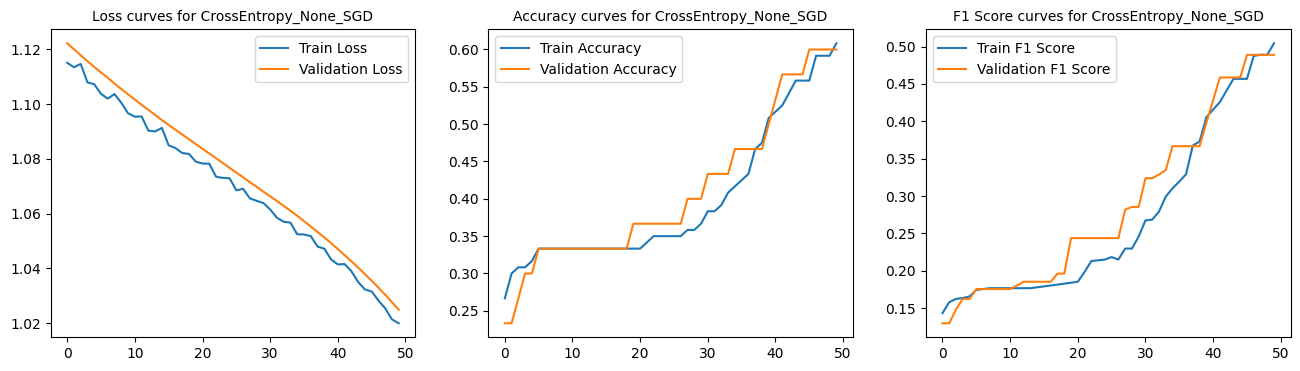

For CrossEntropy_None_SGD:
  - Training time: 0.7990 seconds
  - Final Training Accuracy: 0.6083
  - Final Validation Accuracy: 0.6000
  - Final Training F1 Score: 0.5044
  - Final Validation F1 Score: 0.4889



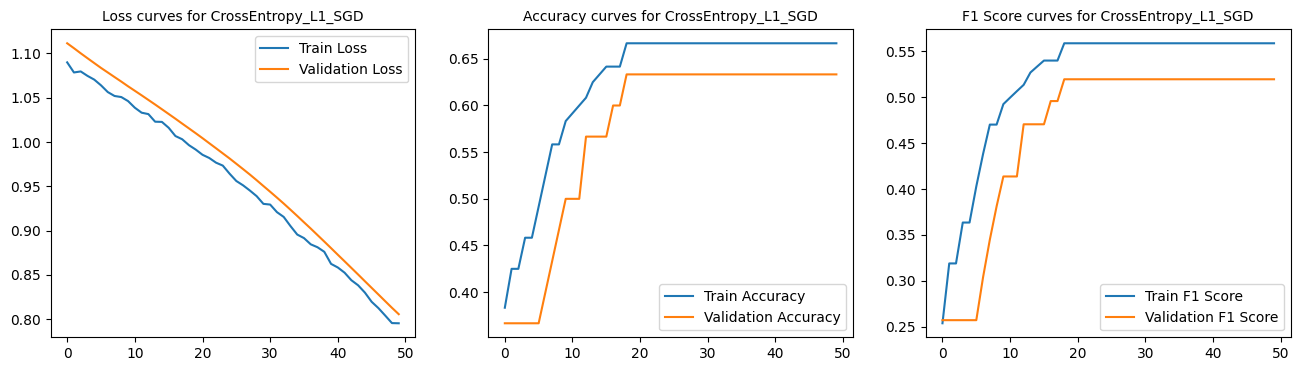

For CrossEntropy_L1_SGD:
  - Training time: 0.6115 seconds
  - Final Training Accuracy: 0.6667
  - Final Validation Accuracy: 0.6333
  - Final Training F1 Score: 0.5588
  - Final Validation F1 Score: 0.5195



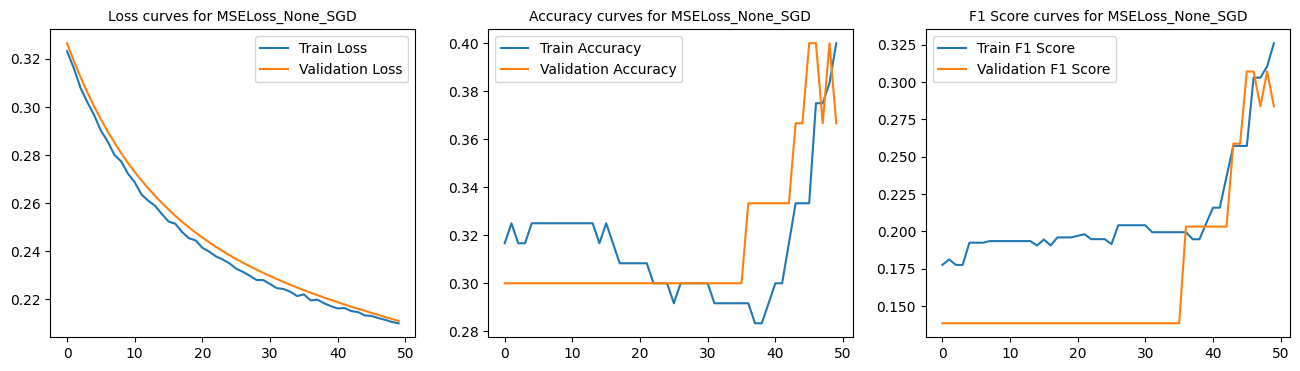

For MSELoss_None_SGD:
  - Training time: 0.6877 seconds
  - Final Training Accuracy: 0.4000
  - Final Validation Accuracy: 0.3667
  - Final Training F1 Score: 0.3261
  - Final Validation F1 Score: 0.2838



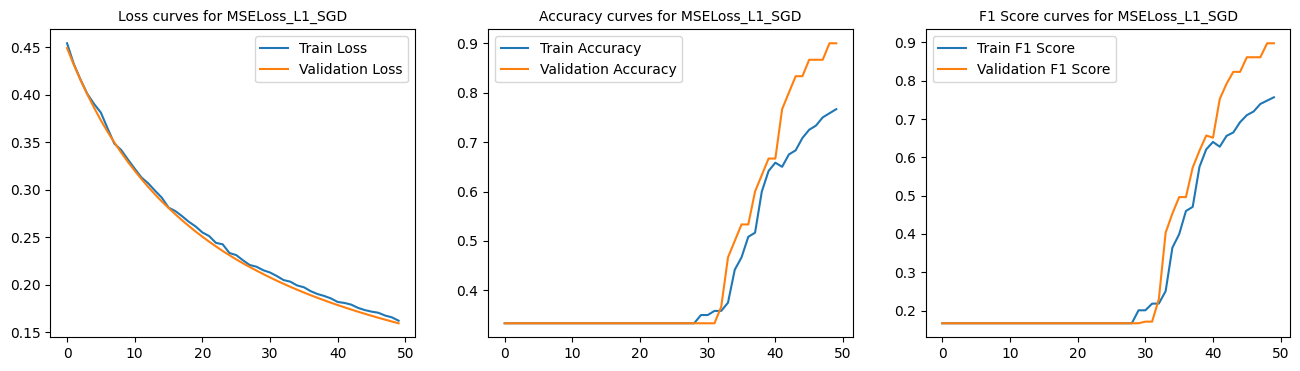

For MSELoss_L1_SGD:
  - Training time: 0.6906 seconds
  - Final Training Accuracy: 0.7667
  - Final Validation Accuracy: 0.9000
  - Final Training F1 Score: 0.7568
  - Final Validation F1 Score: 0.8979



In [10]:
results = {}

for loss_name, criterion in loss_functions.items():
    for reg_name, reg_params in regularization.items():
        for opt_name, opt_class in optimizers.items():
            config_name = f"{loss_name}_{reg_name}_{opt_name}"
            model = SimpleFeedForwardNN()
            optimizer = opt_class(model.parameters(), lr=0.01, weight_decay=reg_params['weight_decay'])
            train_loss, val_loss = [], []
            train_accuracy, val_accuracy = [], []
            train_f1, val_f1 = [], []
            start_time = time.time()

            for epoch in range(50):
                model.train()
                epoch_train_loss = 0
                y_true_train, y_pred_train = [], []
                for inputs, targets in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    if loss_name in ["MSELoss", "SmoothL1Loss"]:
                        criterion_targets = torch.nn.functional.one_hot(targets, 3).float()
                    else:
                        criterion_targets = targets
                    loss = criterion(outputs, criterion_targets)
                    loss.backward()
                    optimizer.step()
                    epoch_train_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    y_true_train.extend(targets.tolist())
                    y_pred_train.extend(predicted.tolist())

                train_loss.append(epoch_train_loss / len(train_loader))
                train_accuracy.append(accuracy_score(y_true_train, y_pred_train))
                train_f1.append(f1_score(y_true_train, y_pred_train, average='weighted'))

                # Evaluación del modelo en el conjunto de validación
                model.eval()
                epoch_val_loss = 0
                y_true_val, y_pred_val = [], []
                with torch.no_grad():
                    for inputs, targets in test_loader:
                        outputs = model(inputs)
                        if loss_name in ["MSELoss", "SmoothL1Loss"]:
                            criterion_targets = torch.nn.functional.one_hot(targets, 3).float()
                        else:
                            criterion_targets = targets
                        loss = criterion(outputs, criterion_targets)
                        epoch_val_loss += loss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        y_true_val.extend(targets.tolist())
                        y_pred_val.extend(predicted.tolist())

                val_loss.append(epoch_val_loss / len(test_loader))
                val_accuracy.append(accuracy_score(y_true_val, y_pred_val))
                val_f1.append(f1_score(y_true_val, y_pred_val, average='weighted'))

            # Visualizar las curvas
            plt.figure(figsize=(16, 4))
            plt.subplot(1, 3, 1)
            plt.plot(train_loss, label='Train Loss')
            plt.plot(val_loss, label='Validation Loss')
            plt.title(f'Loss curves for {config_name}',  fontsize=10)
            plt.legend()

            plt.subplot(1, 3, 2)
            plt.plot(train_accuracy, label='Train Accuracy')
            plt.plot(val_accuracy, label='Validation Accuracy')
            plt.title(f'Accuracy curves for {config_name}',  fontsize=10)
            plt.legend()

            plt.subplot(1, 3, 3)
            plt.plot(train_f1, label='Train F1 Score')
            plt.plot(val_f1, label='Validation F1 Score')
            plt.title(f'F1 Score curves for {config_name}',  fontsize=10)
            plt.legend()
            plt.show()
            
            end_time = time.time()
            total_time = end_time - start_time

            print(f"For {config_name}:")
            print(f"  - Training time: {total_time:.4f} seconds")
            print(f"  - Final Training Accuracy: {train_accuracy[-1]:.4f}")
            print(f"  - Final Validation Accuracy: {val_accuracy[-1]:.4f}")
            print(f"  - Final Training F1 Score: {train_f1[-1]:.4f}")
            print(f"  - Final Validation F1 Score: {val_f1[-1]:.4f}")
            print()
            results[config_name] = {'train_loss': train_loss, 'val_loss': val_loss,'train_accuracy': train_accuracy, 'val_accuracy': val_accuracy,'train_f1': train_f1, 'val_f1': val_f1, 'time': total_time}


In [11]:
def evaluate_model(model, criterion, test_loader, loss_name):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            
            if loss_name in ["MSELoss", "SmoothL1Loss"]:
                targets = torch.nn.functional.one_hot(targets, 3).float()
                
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [12]:
test_loss = evaluate_model(model, criterion, test_loader, loss_name)
test_loss

0.15940091013908386